# Exercise 2: A Model with Linear and Non-linear Parameters

*This is the companion notebook to Exercise 2 in Hogg, Price-Whelan & Leistedt (2020).*

In [1]:
# Standard library packages
import os
import sys

# Third-party packages
import astropy.table as at
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Included with this repository
from helpers import log_multivariate_gaussian

# Set up a deterministic random number generator:
#  Note: this requires numpy>=1.17
rnd = np.random.Generator(np.random.PCG64(seed=8675309))

For this exercise, we will use a sinusoidal function as our parametric model, with three linear parameters (the amplitudes $\alpha, \beta$ and a constant offset $\gamma$) and one non-linear parameter (the frequency $\omega$):
$$
f(x \,;\, \alpha, \beta, \gamma, \omega) = \alpha\, \cos(\omega \, x) + \beta \, \sin(\omega \, x) + \gamma
$$

To start off, let's define true parameter values, which we will use to generate the simulated data,
$(\alpha, \beta, \gamma, \omega)$:

In [2]:
true_pars = (3.21, 2.44, 13.6, 1.27)
K = len(true_pars) - 1  # number of *linear* parameters

Let's define a function to evaluate this model, given a set of parameter values:

In [3]:
def model(x, α, β, γ, ω):
    return (α * np.cos(ω * x) + 
            β * np.sin(ω * x) + 
            γ)

We can now generate our simulated data and store it as an astropy `Table` object for easy writing and printing to latex (for including in the companion paper). We round the values to make it more concise when including the data in the companion article. The ranges used below in the random number generators were chosen arbitrarily.

In [4]:
N = 4

t = at.Table()
t['x'] = np.round(np.sort(rnd.uniform(-5, 5, size=N)), 
                  decimals=1)
sigma_y = np.round(np.sort(rnd.uniform(0.1, 0.5, size=N)), 
                   decimals=1)
t['y'] = np.round(rnd.normal(model(t['x'], *true_pars),
                             sigma_y),
                  decimals=1)
t['sigma_y'] = sigma_y

t.write('data2.csv', overwrite=True)
t.write(sys.stdout, format='ascii.latex')

\begin{table}
\begin{tabular}{ccc}
x & y & sigma_y \\
-1.2 & 11.2 & 0.2 \\
1.3 & 16.1 & 0.2 \\
3.1 & 10.2 & 0.3 \\
4.1 & 13.5 & 0.3 \\
\end{tabular}
\end{table}


We again assume that the data are independent so that the covariance tensor of the data, $\mathrm{C}$, is diagonal:

In [5]:
C = np.diag(t['sigma_y'] ** 2)

We can now also specify the Gaussian prior parameters (mean `mu` and variance tensor `L`) for the two amplitudes ($\alpha$, $\beta$) and the constant offset ($\gamma$):

In [6]:
mu = np.array([0, 0, 0])

sigmas = np.array([5, 5, 10])
L = np.diag(sigmas ** 2)

We are not able to analytically marginalize over all of the parameters because of the nonlinear parameter $\omega$. However, we can still marginalize over the subset of linear parameters given a value for $\omega$ to compute the factorizations (to get $\boldsymbol{a}, \boldsymbol{A}, \boldsymbol{b}, \boldsymbol{B}$). A consequence of this is that the design matrix in this problem is therefore a function of the nonlinear parameter $\omega$:

In [7]:
def design_matrix(x, ω):
    M = np.stack((np.cos(ω * x),
                  np.sin(ω * x),
                  np.ones_like(x))).T
    return M

At any value of $\omega$, we can therefore still compute the MAP parameter vector $a$, the posterior variance tensor $A$, and the vector and the corresponding prior-optimal vector and tensor $b$, $B$ (following the notation in the companion article, Equations 10–13) conditioned on $\omega$. This enables us to compute the value of the log-marginal-likelihood, conditioned on $\omega$. If the linear parameters were nuisance parameters, we have therefore reduced the dimensionality of our problem to a 1D inference problem (for $\omega$). This dimensionality reduction can be a huge help for performance, or for doing inference in the non-nuisance parameters! For example, if the posterior pdf over $\omega$ or the non-nuisance parameters is complex, multi-modal, or difficult to sample with MCMC, this dimensionality reduction could enable other, brute-force methods that would be intractable with the full dimensionality of the nuisance and non-nuisance parameters. We will demonstrate this later.

First, we can write a function that takes a value of $\omega$ and computes the terms we need from the factorization:

In [8]:
def compute_aA_bB(omega, x, y, C, mu, L):
    M = design_matrix(x, omega)
    
    Cinv = np.linalg.inv(C)
    Linv = np.linalg.inv(L)
    
    b = M @ mu
    B = C + M @ L @ M.T

    Ainv = Linv + M.T @ Cinv @ M
    A = np.linalg.inv(Ainv)
    Binv = Cinv - Cinv @ M @ A @ M.T @ Cinv
    a = np.linalg.solve(Ainv, Linv @ mu + M.T @ Cinv @ y)
    
    # By evaluating the Gaussian in b, B, we obtain the value
    #  of the log-marginal-likelihood:
    loglike = log_multivariate_gaussian(y, b, B, Vinv=Binv)

    return {
        'a': a, 'A': A,
        'b': b, 'B': B,
        'ln_marg_likelihood': loglike
    }

As a demonstration, we can evaluate these things at $\omega = 1$:

In [9]:
compute_aA_bB(1., t['x'], t['y'], C, mu, L)

{'a': array([ 1.36572211,  2.09398469, 13.35461393]),
 'A': array([[ 0.05075097, -0.00253481,  0.00094876],
        [-0.00253481,  0.01951542,  0.00205758],
        [ 0.00094876,  0.00205758,  0.0140905 ]]),
 'b': array([0., 0., 0., 0.]),
 'B': array([[125.04      ,  79.97140961,  89.9800207 , 113.8593584 ],
        [ 79.97140961, 125.04      ,  94.31994763,  76.44444148],
        [ 89.9800207 ,  94.31994763, 125.09      , 113.50755765],
        [113.8593584 ,  76.44444148, 113.50755765, 125.09      ]]),
 'ln_marg_likelihood': -76.3276462599734}

Our first task is to evaluate the log-marginal-likelihood on a grid of $\omega$ values. It may therefore be useful to have a wrapper function that calls `compute_aA_bB()` and returns just the likelihood value:

In [10]:
def ln_marginal_likelihood(*args, **kwargs):
    """
    Helper function that extracts and returns the log-marginal-likelihood value.
    """
    res = compute_aA_bB(*args, **kwargs)
    return res['ln_marg_likelihood']

In the exercise prompt, we also assume a prior of the form $p(\omega) \propto 1/\omega$ over the domain (0.1, 100):

In [11]:
def ln_prior_omega(omega):
    A = np.log(100) - np.log(0.1)
    return -np.log(A) - np.log(omega)

We are now set up to evaluate the likelihood - we define a grid of $\omega$ values and run:

In [12]:
omega_lim = (0.1, 1e2)
omega_grid = np.geomspace(*omega_lim, 16_384)
lnlike_grid = np.array([ln_marginal_likelihood(omega, t['x'], t['y'], C, mu, L) 
                        for omega in omega_grid])

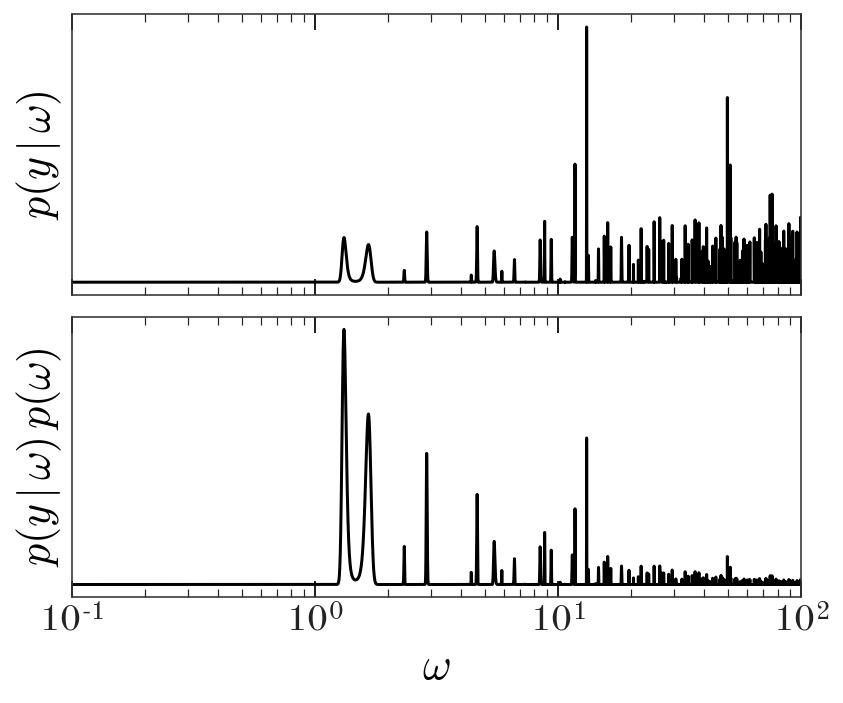

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

axes[0].plot(omega_grid, 
             np.exp(lnlike_grid),
             marker='')

y = lnlike_grid + ln_prior_omega(omega_grid)
axes[1].plot(omega_grid, 
             np.exp(y),
             marker='')

axes[0].set_xscale('log')
axes[0].set_xlim(omega_lim)

# The likelihood values themselves aren't useful:
axes[0].set_yticks([])
axes[1].set_yticks([])

axes[1].set_xlabel(r'$\omega$')
axes[0].set_ylabel(r'$p(y \,|\, \omega)$')
axes[1].set_ylabel(r'$p(y \,|\, \omega)\,p(\omega)$')

fig.tight_layout()

fig.savefig('../paper/exercise2a.pdf')

The likelihood and posterior are both *extremely* multimodal in the nonlinear parameter $\omega$!

---

Our next task is to generate posterior samples in the full set of parameters $(\alpha, \beta, \gamma, \omega)$. As alluded to in the text, standard MCMC methods will have a *very* hard time generating samples from the posterior pdf plotted above. We therefore take a more brute force approach: We can use rejection sampling to do this instead! 

We start by generating a large collection of prior samples over the nonlinear parameter $\omega$ (the number of prior samples here was chosen so that ~512 posterior samples are accepted below):

In [14]:
n_prior_samples = 2**17
prior_omega_samples = np.exp(rnd.uniform(*np.log(omega_lim), 
                                         size=n_prior_samples))

We then evaluate the marginal likelihood for each of the prior samples:

In [15]:
marg_lnlikes = np.array([ln_marginal_likelihood(omega, t['x'], t['y'], C, mu, L) 
                         for omega in prior_omega_samples])

Finally, we rejection sample:

In [16]:
mask = np.exp(marg_lnlikes - marg_lnlikes.max()) > rnd.uniform(size=n_prior_samples)
mask.sum()

1010

The rejection sampling step takes us from our initial collection of prior samples in $\omega$ and cuts these down to ~1,000 posterior samples, but this *only* delivers posterior samples in $\omega$. We therefore need to go to each of the "accepted" posterior samples and generate posterior samples in the linear parameters $(\alpha, \beta, \gamma)$:

In [17]:
def make_full_parameter_vector(omega, x, y, C, mu, L):
    """"""
    res = compute_aA_bB(omega, x, y, C, mu, L)
    linear_sample = rnd.multivariate_normal(res['a'], res['A'])
    return np.concatenate((linear_sample, [omega]))

In [18]:
full_samples = np.array([
    make_full_parameter_vector(omega, t['x'], t['y'], C, mu, L)
    for omega in prior_omega_samples[mask]])

In [19]:
from matplotlib.gridspec import GridSpec

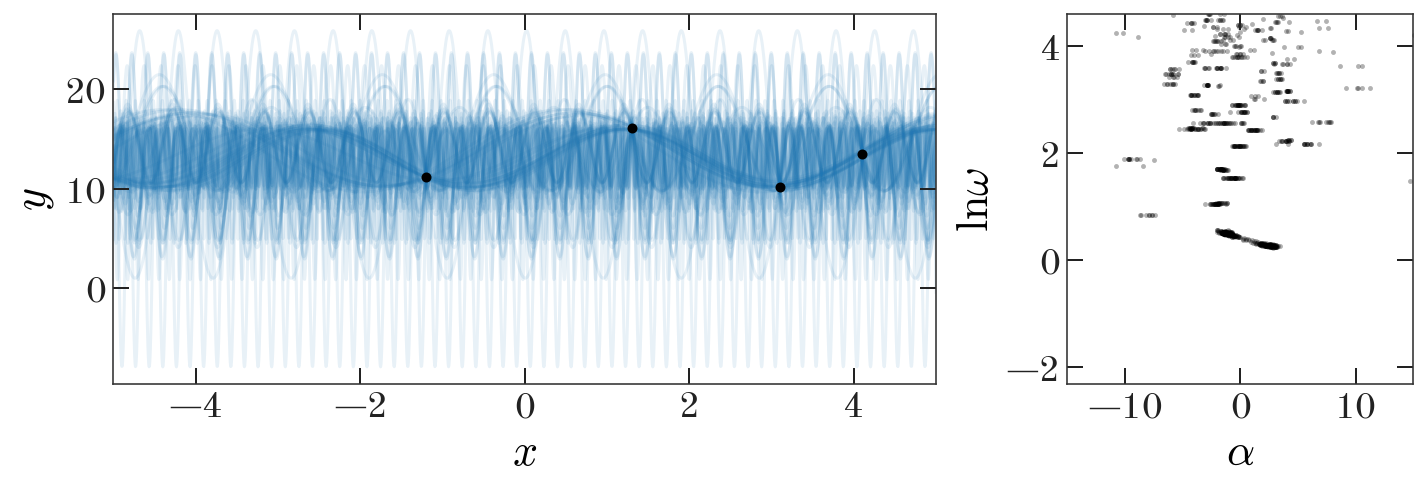

In [20]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig = plt.figure(figsize=(10, 3.5))

gs = GridSpec(1, 6)

ax = fig.add_subplot(gs[:4])
ax.errorbar(t['x'], t['y'], t['sigma_y'], 
            marker='o', ls='none', zorder=10)

grid_x = np.linspace(-5, 5, 2048)
for full_sample in full_samples[:64]:
    ax.plot(grid_x, model(grid_x, *full_sample),
            marker='', alpha=0.1, color='tab:blue', zorder=1)
ax.set_xlim(-5, 5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

# ---

ax = fig.add_subplot(gs[4:])

ax.scatter(full_samples[:, 0], 
           np.log(full_samples[:, 3]),
           marker='o', linewidth=0, 
           alpha=0.3, s=6)

ax.set_xlim(-15, 15)
ax.set_ylim(np.log(0.1), np.log(100))

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\ln\omega$')

fig.tight_layout()
fig.savefig('../paper/exercise2b.pdf')

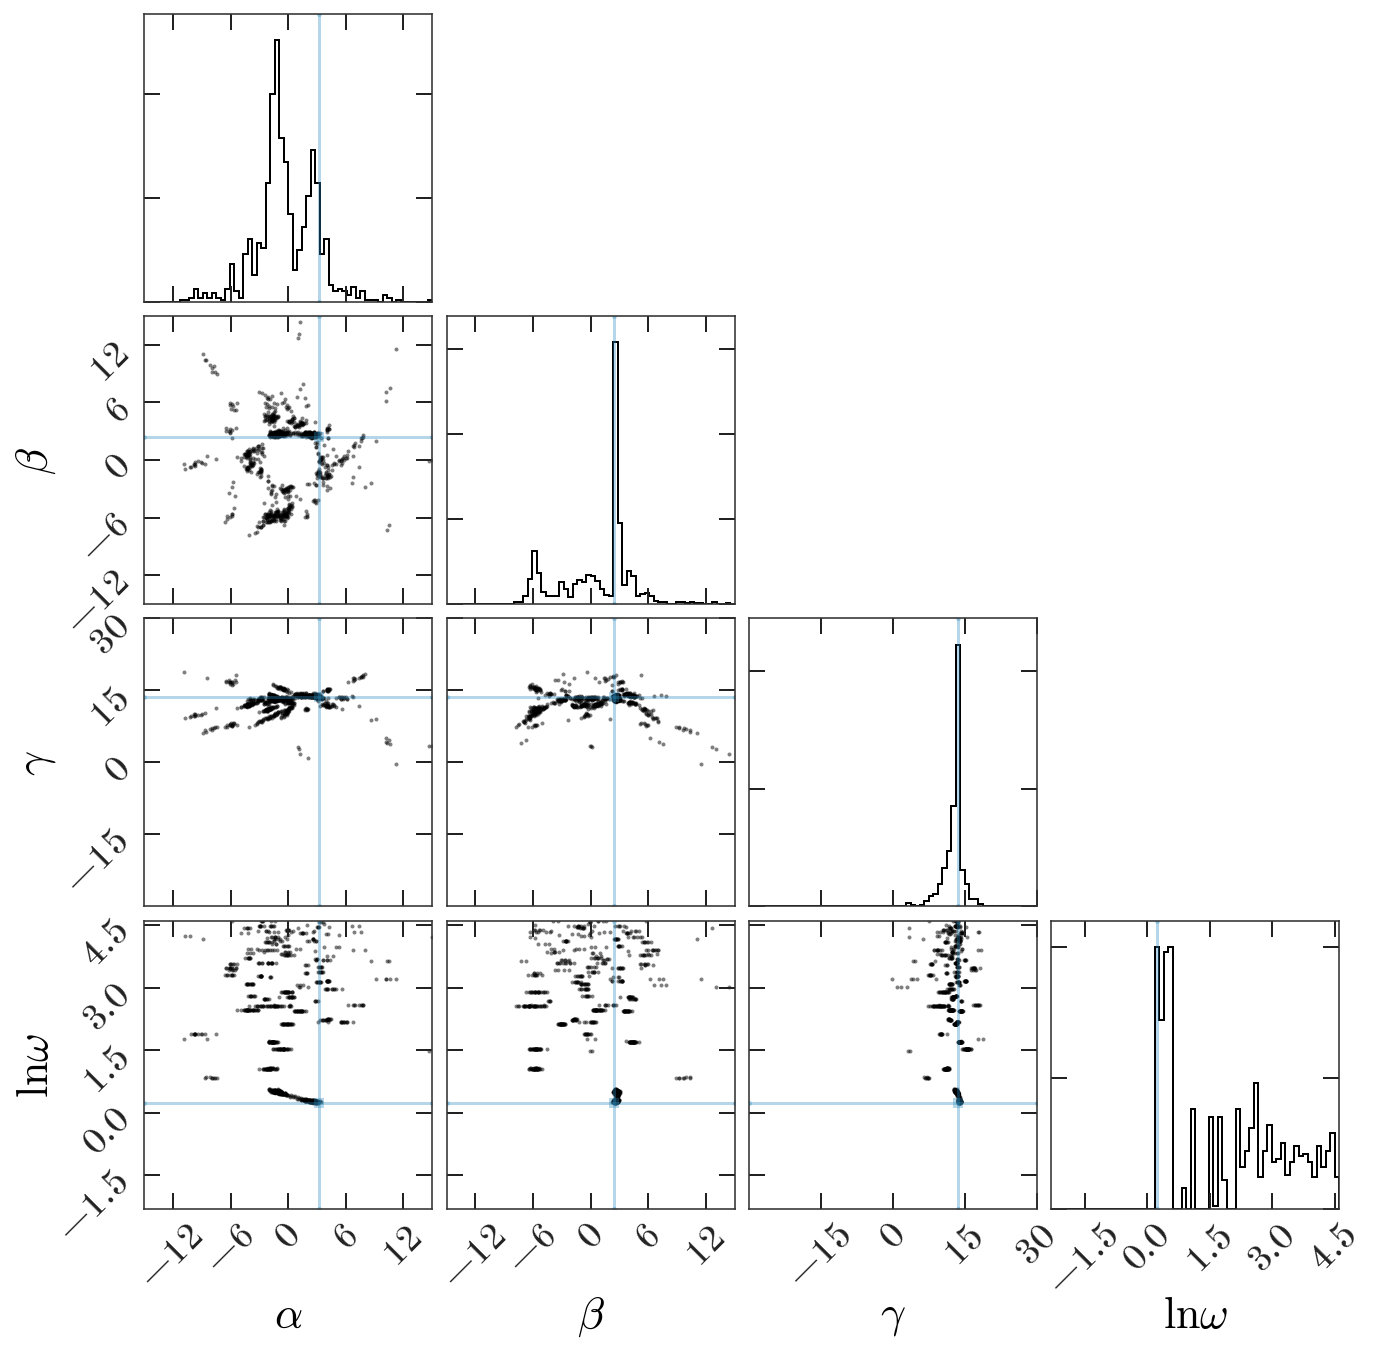

In [22]:
tmp_samples = full_samples.copy()
tmp_samples[:, 3] = np.log(tmp_samples[:, 3])

lims = [(mu[i] - 3*np.sqrt(L[i,i]),
         mu[i] + 3*np.sqrt(L[i,i])) for i in range(K)] + [np.log(omega_lim)]

tmp_pars = np.array(true_pars, copy=True)
tmp_pars[3] = np.log(tmp_pars[3])

fig = corner.corner(tmp_samples, 
                    bins=64,
                    truths=tmp_pars, 
                    range=lims,
                    plot_contours=False,
                    plot_density=False,
                    data_kwargs=dict(alpha=0.5),
                    truth_color=(0.17, 0.55, 0.75, 0.35),
                    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\ln\omega$'])
fig.set_facecolor('w')